# Improved models: XGBoost

Try XGBoost on the dataset with similar parameters. Find some good parameter 
starting points then tune with `optuna`

In [31]:
import pandas as pd
import numpy as np
import os

from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBClassifier

import optuna
from functools import partial

import seaborn as sns 
import matplotlib as mpl 
import matplotlib.pyplot as plt 

In [35]:
mpl.rcParams.update({
    'figure.autolayout': True,
    'figure.dpi': 150
})
sns.set()

## Data pre-processing

In [4]:
DATA_PATH = '../../data/raw'
X_train = pd.read_csv(
    os.path.join(DATA_PATH, 'training_set_features.csv')
).drop('respondent_id',axis =1)

X_test = pd.read_csv(
    os.path.join(DATA_PATH, 'test_set_features.csv')
).drop('respondent_id',axis =1)

y_train = pd.read_csv(
    os.path.join(DATA_PATH, 'training_set_labels.csv')
).drop('respondent_id',axis =1)

sub = pd.read_csv(os.path.join(DATA_PATH, 'submission_format.csv'))

## Models

In [24]:
num_features = X_train.columns[X_train.dtypes != "object"].values
cat_features = X_train.columns[X_train.dtypes == "object"].values

num_transformer = Pipeline([
    ('scale', StandardScaler()),
    ('impute', KNNImputer(n_neighbors = 10))
])

cat_transformer = Pipeline([
    ('impute', SimpleImputer(strategy = 'constant', fill_value = 'missing')),
    ('encode', OneHotEncoder(drop = 'first'))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

## Default

First try with default parameters

In [8]:
xgb_model = Pipeline([
    ('pre', preprocessor),
    ('xgb', MultiOutputClassifier(XGBClassifier(objective = 'binary:logistic')))
])

In [24]:
cv = cross_validate(
    estimator = xgb_model,
    X = X_train,
    y = y_train,
    cv = 5,
    scoring = 'roc_auc',
    n_jobs = -1
)
print(np.mean(cv['test_score']))
print(np.std(cv['test_score']))

0.8559122059029292
0.004783469904348547


Again better than previous best, so refit and make predictions

In [9]:
xgb_model.fit(X_train, y_train)
preds = xgb_model.predict_proba(X_test)
sub['h1n1_vaccine'] = preds[0][:,1]
sub['seasonal_vaccine'] = preds[1][:,1]
sub.to_csv('../../results/predictions/base_xgb.csv', index = False)

## Changing number of estimators

In [26]:
cv_scores = []
best_score = 0
for n in [100, 200, 500, 1000]:
    xgb_model = Pipeline([
        ('pre', preprocessor),
        ('xgb', MultiOutputClassifier(XGBClassifier(
            learning_rate = 0.01,
            n_estimators = n,
            max_depth = 5,
            subsample = 0.8,
            colsample_bytree = 0.8,
            objective = 'binary:logistic',
            n_jobs = 2
        )))
    ])
    score = cross_val_score(
        estimator = xgb_model,
        X = X_train,
        y = y_train,
        scoring = 'roc_auc',
        cv = 4,
        n_jobs = 4
    )
    print(np.mean(score))
    cv_scores.append(np.mean(score))
    if cv_scores[-1] > best_score:
        best_score = cv_scores[-1]
        best_n = n


0.8451794396930609
0.849546831858427
0.8573294201552641
0.859750033340273


In [27]:
best_score

0.859750033340273

In [28]:
best_n

1000

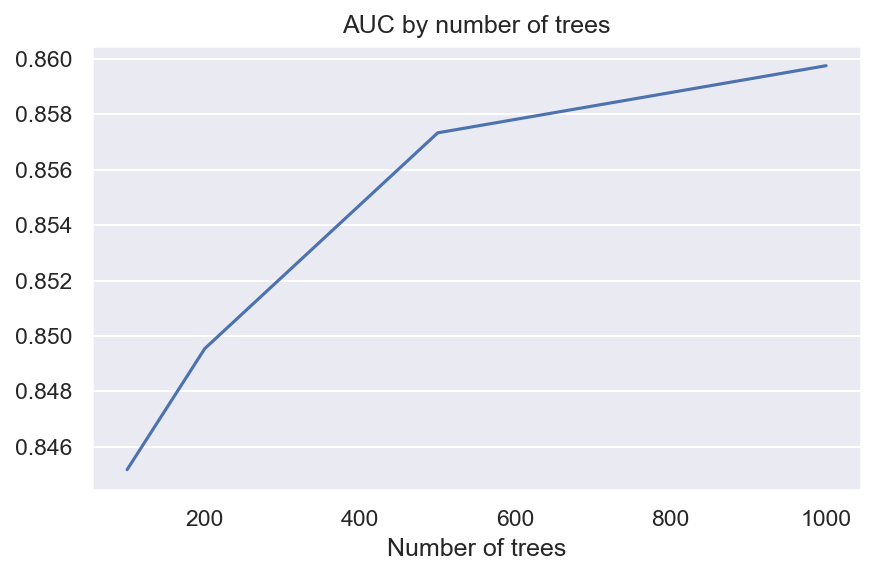

In [37]:
fig, ax = plt.subplots()
ax.plot([100,200,500,1000], cv_scores)
ax.set_xlabel('Number of trees')
ax.grid(axis = 'x')
ax.set_title('AUC by number of trees')
fig.savefig('../../results/figures/ntrees_xgb_performance.png')

### 

## Depth and child weight

In [54]:
test_params = {
    'xgb__estimator__max_depth': np.arange(2, 10, 2),
    'xgb__estimator__min_child_weight': np.arange(2, 10, 2)
}

In [52]:
xgb_model = Pipeline([
    ('pre', preprocessor),
    ('xgb', MultiOutputClassifier(XGBClassifier(
        learning_rate = 0.01,
        n_estimators = 1000,
        subsample = 0.8,
        colsample_bytree = 0.8,
        objective = 'binary:logistic',
        n_jobs = 2
    )))
])


In [57]:
search_res = GridSearchCV(
    param_grid = test_params,
    estimator = xgb_model,
    cv = 5,
    n_jobs = 4,
    scoring = 'roc_auc',
    refit= True,
    verbose = 10
)

In [61]:
search_res.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  6.0min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  9.6min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 12.7min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 19.9min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 25.5min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 34.8min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 42.5min
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed: 59.0min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scale',
                                                                                          StandardScaler()),
                                                                                         ('impute',
                                                                                          KNNImputer(n_neighbors=10))]),
                                                                         array(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask',
       'behavioral_wash_hands', 'behavioral_large_gatherings',
       'behaviora...
       'hhs_geo_region', 'census_msa', 'employment_industry',
       'employment_occupation'], dtype=object))])),
                             

In [62]:
search_res.best_params_

{'xgb__estimator__max_depth': 6, 'xgb__estimator__min_child_weight': 4}

In [64]:
search_res.best_score_

0.860256938504951

Again, better than any of our previous predictions, so we build a submission

In [65]:
preds = search_res.predict_proba(X_test)
sub['h1n1_vaccine'] = preds[0][:,1]
sub['seasonal_vaccine'] = preds[1][:,1]
sub.to_csv('../../results/predictions/tuned_xgb_pred.csv', index = False)

Check for sanity

In [66]:
sub.head(10)

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.089909,0.214919
1,26708,0.026798,0.034606
2,26709,0.216079,0.652403
3,26710,0.675234,0.899938
4,26711,0.350406,0.582816
5,26712,0.731392,0.973242
6,26713,0.480471,0.631644
7,26714,0.132476,0.116472
8,26715,0.046834,0.106449
9,26716,0.157491,0.874483


### Results

0.8530 AUC on hidden test set, 112/953 on leaderboard
